# Imports:

In [5]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image, ImageOps

# --- CUSTOM IMPORTS ---
from src.utils import extractCoordinates, aspect_crop, haversine_distance, plot_images_from_dataloader, setup_TensorBoard_writers, log_error_map
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3, HierarchicalLocalizer

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image preprocessing:

In [6]:
# Setup paths
RAW_IMAGE_FOLDER = r"data"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1479:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [7]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Initializing train dataset...
Caching 1183 images in RAM...


100%|██████████| 1183/1183 [00:02<00:00, 420.74it/s]


Initializing validation dataset...
Caching 296 images in RAM...


100%|██████████| 296/296 [00:00<00:00, 422.89it/s]


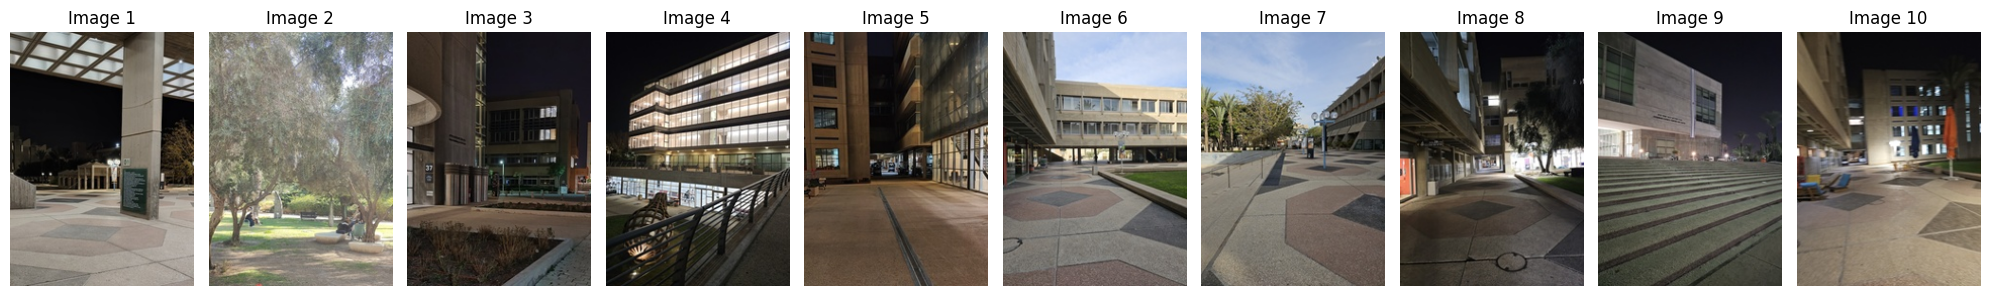

In [8]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        target_size=(182, 252),
        is_train=False # Set to True if you want to apply data augmentations
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        target_size=(182, 252),
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [22]:
localizer = HierarchicalLocalizer(train_dataset)

Loading models on cuda...


Using cache found in C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main
Building Index: 100%|██████████| 37/37 [00:58<00:00,  1.58s/it]


In [31]:
print("\n--- Running Evaluation ---")

def haversine_distance1(coord1, coord2):
    R = 6371000.0
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


total_error = 0.0
errors = []

# Create the tqdm object explicitly
pbar = tqdm(range(len(val_dataset)), desc="Validating")

for i in pbar:
    img, actual_gps = val_dataset[i]
    
    # Predict
    pred_gps = localizer.predict(img,top_n_matches=10, MIN_INLIER_THRESHOLD=100, debug=False)
    
    # Measure
    err = haversine_distance1(pred_gps, actual_gps.numpy())
    errors.append(err)
    
    # # Optionally, display the matched image alongside the query image
    # plt.figure(figsize=(8, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    # plt.title(f'Query Image: {val_dataset.image_paths[i].split(os.sep)[-1]}')
    # plt.axis('off')
    # plt.subplot(1, 2, 2)
    # plt.imshow(pred_img[0].permute(1, 2, 0).cpu().numpy())
    # plt.title('Matched Image: {} \n Error: {:.1f} m, Inlier Matches: {}'.format( val_dataset.image_paths[i].split(os.sep)[-1], err, inlier_matches))
    # plt.axis('off')
    # plt.show()

    # Update running stats
    total_error += err
    avg_error = total_error / (i + 1)
    
    # Update the progress bar
    # displaying current image error and the running average
    pbar.set_postfix({'curr': f"{err:.1f}m", 'avg': f"{avg_error:.1f}m"})

print(f"Final Average Error: {np.mean(errors):.2f} meters")


--- Running Evaluation ---


Validating: 100%|██████████| 296/296 [07:43<00:00,  1.57s/it, curr=19.7m, avg=21.4m] 

Final Average Error: 21.37 meters


Mean Error: 21.37 meters
Median Error: 15.71 meters
Standard Deviation: 20.12 meters
Minimum Error: 0.00 meters
Maximum Error: 163.72 meters


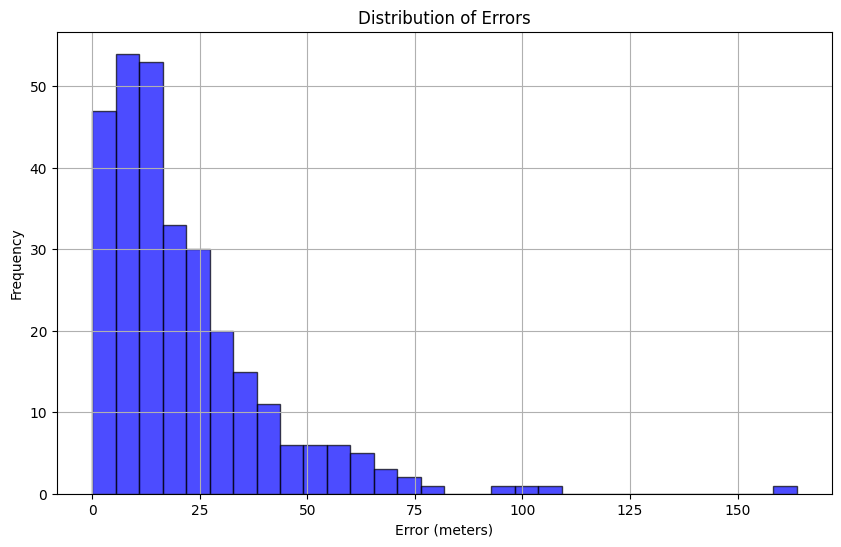

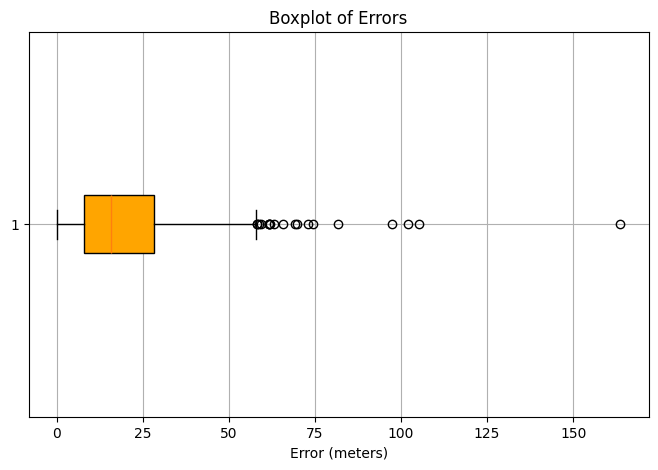

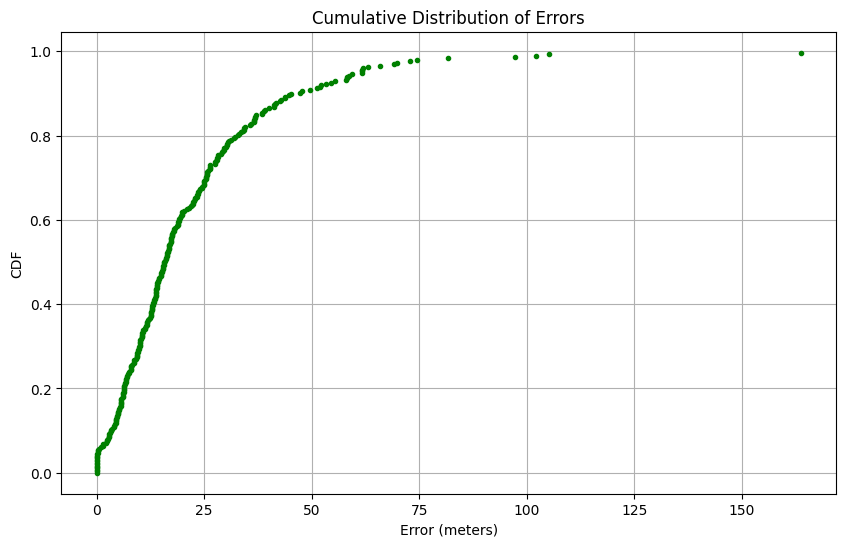

In [33]:
# Convert errors to a numpy array for easier manipulation
errors_array = np.array(errors)

# Basic statistics
print(f"Mean Error: {np.mean(errors_array):.2f} meters")
print(f"Median Error: {np.median(errors_array):.2f} meters")
print(f"Standard Deviation: {np.std(errors_array):.2f} meters")
print(f"Minimum Error: {np.min(errors_array):.2f} meters")
print(f"Maximum Error: {np.max(errors_array):.2f} meters")

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(errors_array, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Errors")
plt.xlabel("Error (meters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot boxplot of errors
plt.figure(figsize=(8, 5))
plt.boxplot(errors_array, vert=False, patch_artist=True, boxprops=dict(facecolor='orange'))
plt.title("Boxplot of Errors")
plt.xlabel("Error (meters)")
plt.grid(True)
plt.show()

# Cumulative distribution function (CDF) plot
sorted_errors = np.sort(errors_array)
cdf = np.arange(len(sorted_errors)) / float(len(sorted_errors))
plt.figure(figsize=(10, 6))
plt.plot(sorted_errors, cdf, marker='.', linestyle='none', color='green')
plt.title("Cumulative Distribution of Errors")
plt.xlabel("Error (meters)")
plt.ylabel("CDF")
plt.grid(True)
plt.show()
